<a href="https://www.coursera.org/learn/applied-data-science-capstone/"><img src = "https://seetorontonow.mx/uploads/2018/01/kayak-on-lake-ontario-looking-at-toronto-skyline.jpg" width = 500> </a>

<h1 align=center><font size = 5>Segmenting and Clustering Neighborhoods in Toronto</font></h1>
<h1 align=center><font size = 4>By Miguel Lira Vidrio</font></h1>
<h1 align=center><font size = 2.5>For Coursera Applied Data Science Capstone</font></h1>

## Introduction
In this notebook is presented a work around Toronto Neighborhoods to understand their characteristics and segmenting them.
The neighborhoods information was obteined from Wikipedia (https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M) and grouping by Postalcode. Also the geo coordinates was added to each Postalcode. The Foursquare API was used to get venues around of the PostalCode Coordinates. With the collected information a dataframe was built and included top 10 venues categories for each postalcode, venues density per square meters. Finally we applied a kmeans algorithm.  

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

1. <a href="#item1">Create Toronto Neighborhoods Dataframe</a>

2. <a href="#item2">Get PostalCode Coordinates</a>

3. <a href="#item3">Get Venues from Foursquare API</a>

4. <a href="#item4">Cluster Neighborhoods</a>

5. <a href="#item5">Examine Results</a>    
</font>
</div>

##### Install and import libraries:

In [1]:

!pip install tensorflow
!pip install geopy
!pip install folium
!pip install bs4
!pip install googlemaps
!pip install plotly
!pip install cufflinks

    100% |████████████████████████████████| 1.6MB 14.8MB/s ta 0:00:01
    100% |████████████████████████████████| 890kB 21.4MB/s ta 0:00:01
  Running setup.py bdist_wheel for html5lib ... done
  Stored in directory: /home/dsxuser/.cache/pip/wheels/50/ae/f9/d2b189788efcf61d1ee0e36045476735c838898eef1cad6e29
Successfully built html5lib
  Found existing installation: html5lib 0.999999999
    Uninstalling html5lib-0.999999999:
      Successfully uninstalled html5lib-0.999999999
  Found existing installation: bleach 2.0.0
    Uninstalling bleach-2.0.0:
      Successfully uninstalled bleach-2.0.0
    100% |████████████████████████████████| 92kB 11.7MB/s ta 0:00:01
  Running setup.py bdist_wheel for bs4 ... done
  Stored in directory: /home/dsxuser/.cache/pip/wheels/a0/b0/b2/4f80b9456b87abedbc0bf2d52235414c3467d8889be38dd472
Successfully built bs4
  Running setup.py bdist_wheel for googlemaps ... done
  Stored in directory: /home/dsxuser/.cache/pip/wheels/3c/3f/25/ce6d7722dba07e5d4a12d27ab38f

In [2]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
import json
from pandas.io.json import json_normalize
import folium # plotting library
from bs4 import BeautifulSoup #Library to scraping info. from a web portal such a wikipedia.


print('Libraries are correctly imported')

Libraries are correctly imported


## 1. Create Toronto Neighborhoods DataFrame

The Toronto Neighborhoods information is available in the following Wikipedia Page: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M 
BeautifulScrape was used to scrape the table content. A pandas dataframe was built from content in order to know which Neighborhoods belongs to a PostalCode and Borough with the follow structure:
<img src="https://d3c33hcgiwev3.cloudfront.net/imageAssetProxy.v1/7JXaz3NNEeiMwApe4i-fLg_40e690ae0e927abda2d4bde7d94ed133_Screen-Shot-2018-06-18-at-7.17.57-PM.png?expiry=1559779200000&hmac=dyAVJgKU6e2BrXIIHUTkjX3L4kgDdkzjFF2IEV6tmP4" width = 400>

In the table on the Wikipedia page, is possible see that M5A is listed twice and has two neighborhoods: Harbourfront and Regent Park. For our purpuse these two rows was combined into one row with the neighborhoods separated with a comma as shown in row 11 in the above table.

Also the Wikipedia table has PostalCode with Not assigned Boroughs and Neighborhoods. The analysis required process the cells that had an assigned borough. When a PostalCode had borough but a Not assigned neighborhood, the neighborhood was replaced with borough name. 

In the next cells the code to create the desire dataframe is presented.


1) Toronto Neighborhood Data from Wikipedia was processed to a Dataframe.

In [3]:
#Scrape content from Wikipedia table:
url=requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M").text
soup=BeautifulSoup(url,"html.parser")
tb = soup.find('table', class_='wikitable')
rows = tb.find_all('tr')
l = []
for tr in rows:
    td = tr.find_all('td')
    row = [tr.text for tr in td]
    l.append(row)
#Create a pandas dataframe: 
toronto_df=pd.DataFrame(l, columns=["PostalCode", "Borough","Neighborhood"])
toronto_df=toronto_df.drop([0])
toronto_df=toronto_df.reset_index(drop=True)
#Replace dirty string:
toronto_df["Neighborhood"]=toronto_df["Neighborhood"].str.replace('\n', '')

2) Only assigned Boroughs were selected. All "Not assigned" Neighborhood records were replaced with the correspondent Borough name.

In [4]:
totalPost=toronto_df["PostalCode"].unique().shape[0]
toronto_df=toronto_df.loc[toronto_df["Borough"]!="Not assigned"]
index=toronto_df.loc[toronto_df["Neighborhood"]=="Not assigned"].index.values.astype(int)
for i in index:
    toronto_df.at[i, 'Neighborhood'] = toronto_df.at[i, 'Borough']
PC=toronto_df["PostalCode"].unique().shape[0]
PC_na_Boroughs=totalPost-PC

3) Adjusted DataFrame to contains Borough, Postalcode and a list of related Neighborhoods separated with coma.

In [5]:
toronto_df=toronto_df.groupby(["PostalCode", "Borough"])["Neighborhood"].apply(lambda x:"%s" % ", ".join(x)).to_frame()
toronto_df.reset_index(level=1, inplace=True)
toronto_df.reset_index(level=0, inplace=True)

4) In the follow cell the results from the code are presented:

In [6]:
print("At the beginning we had: {} Postalcodes.".format(totalPost))
print('A total of {} PostalCodes was discarded.'.format(PC_na_Boroughs))
print("Only {} Neighborhoods was replaced with the Borough Name.".format(index.shape[0]))
print("The final shape of our dataframe is {}".format(toronto_df.shape))

At the beginning we had: 180 Postalcodes.
A total of 77 PostalCodes was discarded.
Only 1 Neighborhoods was replaced with the Borough Name.
The final shape of our dataframe is (103, 3)


In [7]:
toronto_df.sample(n=10)

,PostalCode,Borough,Neighborhood
25,M3A,North York,Parkwoods
59,M5J,Downtown Toronto,"Harbourfront East, Toronto Islands, Union Station"
102,M9W,Etobicoke,Northwest
46,M4R,Central Toronto,North Toronto West
70,M5X,Downtown Toronto,"First Canadian Place, Underground city"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
62,M5M,North York,"Bedford Park, Lawrence Manor East"
99,M9P,Etobicoke,Westmount
83,M6R,West Toronto,"Parkdale, Roncesvalles"
91,M8Y,Etobicoke,"Humber Bay, King's Mill Park, Kingsway Park So..."


## 2. Get PostalCode Coordinates

The dataframe created with Wikipedia table content do not possess coordinates for every single PostalCode. Unfortunately, the foursquare API works better with coordinates.
Googlemaps library was used to get latitude and longitude coordinates for each PostalCode. In the cells below the steps followed to get coordinates are presented.

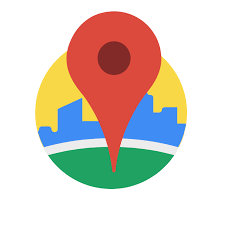

1) First the googlemaps library was added. Also in order to obtain better results in the location of coordinates directions variable was created.

In [8]:
import googlemaps
directions=toronto_df["PostalCode"]+ ", ONTARIO, CANADA"

2) The Google Cloud Secret Key was specified.

In [9]:
# The code was removed by Watson Studio for sharing.

3) Latitude and longitude were got from grocode API and added to the Toronto_Neighborhood Dataframe.

In [10]:
gmaps = googlemaps.Client(key=my_key)
i=len(directions)
lat=np.zeros(i)
long=np.zeros(i)
for j in range(i):
    direction=directions[j]
    geocode_result = gmaps.geocode(direction)
    lat[j]=geocode_result[0]["geometry"]["location"]["lat"]
    long[j]=geocode_result[0]["geometry"]["location"]["lng"]
toronto_df["Latitude"]=lat
toronto_df["Longitude"]=long

4) In the next cell is possible see the resultant dataframe from the code above.

In [11]:
toronto_df.sample(n=10)

,PostalCode,Borough,Neighborhood,Latitude,Longitude
55,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
89,M8W,Etobicoke,"Alderwood, Long Branch",43.602414,-79.543484
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.711112,-79.284577
63,M5N,Central Toronto,Roselawn,43.711695,-79.416936
3,M1G,Scarborough,Woburn,43.770992,-79.216917
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",43.716316,-79.239476
29,M3J,North York,"Northwood Park, York University",43.767980,-79.487262
51,M4X,Downtown Toronto,"Cabbagetown, St. James Town",43.667967,-79.367675
67,M5T,Downtown Toronto,"Chinatown, Grange Park, Kensington Market",43.653206,-79.400049
35,M4B,East York,"Woodbine Gardens, Parkview Hill",43.706397,-79.309937


## 3. Get Veneus from Foursquare API

This section contains the steps followed to get venues from Foursquare in a properly way. Initially it was thought to work the parameters defined in the Segmenting and Clustering New York Neighborhoods I mean 500 meters of radius in every search. To not take risks this section has two parts:

1) Data exploration and refinement
2) Get Venues from Foursquare.


<img src="https://ss0.4sqi.net/img/developers/products/places-api-538e392a138bea16aa61260a55a875b4.png" width = 200>


#### 3.1. Data Exploration

1) Firstly a folium map was generated to understand the Toronto PostalCodes distribution.

In [12]:
address = 'Toronto, ONTARIO'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of TORONTO City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of TORONTO City are 43.653963, -79.387207.


In [13]:
Toronto_map = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto_df['Latitude'], toronto_df['Longitude'], toronto_df['Borough'], toronto_df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(Toronto_map)  
    
Toronto_map

2) The parameter used in New York Neighborhoods (radius=500 meters) was added to Toronto_map

In [14]:
Toronto_map = folium.Map(location=[latitude, longitude], zoom_start=12)
# add markers and radius to map
for lat, lng, borough, neighborhood in zip(toronto_df['Latitude'], toronto_df['Longitude'], toronto_df['Borough'], toronto_df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(Toronto_map)  
    folium.Circle(
        radius=500,
        popup=label,
        location=[lat, lng],
        color='#3186cc',
        fill=True,
        fill_color='#3186cc').add_to(Toronto_map) 
Toronto_map

As the first Toronto Map shown, is confirmed in the map above that in many Postalcode a radius of 500 meters could left behind a lot of venue. Is possible identify a lot of Postalcode overlaping.
To solve the radius problem the GeoPy.Distance.greatCircle was used.

##### Additional Information about how get an properly radius:
Nearest Location:
https://stackoverflow.com/questions/49323171/find-the-nearest-location-using-numpy
Geopy.distance example:
https://www.programcreek.com/python/example/96855/geopy.distance.vincenty
Best way to compute distance:
https://geopy.readthedocs.io/en/stable/#module-geopy.distance


3) The Geopy.Distance.Greatcircle library was loaded and a function to find the nearest postalcode for each location was created.

In [15]:
from geopy.distance import great_circle
def find_closest_location(origin, locations):
    locations=np.asarray(locations)
    origin=np.asarray(origin).reshape(1,-1)
    i=len(locations)
    distances=np.zeros(i)
    for j in range(i):
        distances[j] = great_circle(origin, locations[j]).meters
    closest = np.argmin(distances)
    return [round(distances[closest]), closest]

Once the function was created a test was performed to know if the gottan data was correct.

In [16]:
locations=toronto_df[["Latitude", "Longitude"]]
meters, index=find_closest_location(locations[:1], locations[~locations.index.isin([0])])
close_point = locations[:1].append(locations[index+1:index+2])
points=np.asarray(close_point)
print("The distance between {} postalcode and the nearest neighbor ({} postalcode) is: {} meters".format(toronto_df["PostalCode"][0],toronto_df["PostalCode"][index+1], meters) )

The distance between M1B postalcode and the nearest neighbor (M1X postalcode) is: 3397.0 meters


In the output cell below is possible see a map that shows the results from the tested PostalCode above.
The tested PostalCode and its nearest neighbor was drawed in red and is possible locate them into the top right corner.

In [17]:
test_data=toronto_df
i=len(test_data)
tested=np.zeros(i)
tested[0]=1
tested[index+1]=1
tested=np.int64(tested)
test_data["Test"]=tested
colors = ["blue", "red"]
Toronto_map = folium.Map(location=[latitude, longitude], zoom_start=10)
# add markers and radius to map
for lat, lng, borough, neighborhood, tested in zip(test_data['Latitude'], test_data['Longitude'], test_data['Borough'], test_data['PostalCode'], test_data["Test"]):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color=None,
        fill=True,
        fill_color=colors[tested],
        fill_opacity=0.7,
        parse_html=False).add_to(Toronto_map)
folium.PolyLine(points, color="red", label = meters, weight=2.5, opacity=1).add_to(Toronto_map)
Toronto_map 


4) In order to get the radius computed from the distance to neares neighbor a iterate function was defined.

In [18]:
def get_radius(df, locations):
    for lat, lng, idx in zip(df['Latitude'], df['Longitude'], df.index):
        meters, index = find_closest_location([lat,lng], locations[~locations.index.isin([idx])])
        df.at[idx,'Radius'] = np.int64(meters//2) 
    return df

5) In the next steps a new dataframe with a new variable "Radius" was gotten.

In [19]:
toronto_df=toronto_df[["PostalCode", "Borough", "Neighborhood", "Latitude", "Longitude"]]
df_4square=get_radius(toronto_df, locations)
df_4square.head(12)

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Radius
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,1698.0
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,1625.0
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,1205.0
3,M1G,Scarborough,Woburn,43.770992,-79.216917,913.0
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,913.0
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476,1302.0
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",43.727929,-79.262029,1113.0
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.711112,-79.284577,1052.0
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",43.716316,-79.239476,1113.0
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848,1297.0


In [20]:
Toronto_map = folium.Map(location=[latitude, longitude], zoom_start=12)
# add markers and personalized radius to map
for lat, lng, borough, neighborhood, r in zip(df_4square['Latitude'], df_4square['Longitude'], df_4square['Borough'], df_4square['Neighborhood'], df_4square["Radius"]):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(Toronto_map)  
    folium.Circle(
        radius=r,
        popup=label,
        location=[lat, lng],
        color='#3186cc',
        fill=True,
        fill_color='#3186cc').add_to(Toronto_map) 
Toronto_map

In the deployed map above is easy to identify that the circles have better definition. 

#### 3.2 Get venues from Foursquare API

In the cells below the New York Lab code was replicated in order to get venues in every single postal code. After the venues data was collected a data preparation work was develop. Finally a venues dataframe is presented.

1) The new york lab function to get until 100 venues in the specified radius from all the PostaCodes in Toronto was defined.

In [21]:
def getNearbyVenues(ID, description, borough, latitudes, longitudes, radius):
    venues_list=[]
    for i, desc, b, lat, lng, r  in zip(ID, description, borough, latitudes, longitudes, radius ):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            r, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            i,
            desc,
            b,
            lat, 
            lng, 
            r,
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['PostalCode',"Neighborhoods","Borough",'PostalCode Latitude', 
                  'PostalCode Longitude', 
                  "PostalCode Radius",
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']

    return(nearby_venues)

2) Also the Foursquare API credentials, version and the highest number of venues was especified. 

In [22]:
# The code was removed by Watson Studio for sharing.

In [23]:
ID=df_4square["PostalCode"]
description=df_4square['Neighborhood']
borough=df_4square["Borough"]
latitudes=df_4square['Latitude']
longitudes=df_4square['Longitude']
radius=df_4square["Radius"]


In [24]:
venues = getNearbyVenues(ID, description, borough, latitudes, longitudes, radius)

In [25]:
venues.sample(n=5)

,PostalCode,Neighborhoods,Borough,PostalCode Latitude,PostalCode Longitude,PostalCode Radius,Venue,Venue Latitude,Venue Longitude,Venue Category
645,M2N,Willowdale South,North York,43.770120,-79.408493,1023.0,Mel Lastman Square,43.767701,-79.412975,Plaza
2734,M6R,"Parkdale, Roncesvalles",West Toronto,43.648960,-79.456325,781.0,Domani Restaurant & Wine Bar,43.649235,-79.450229,Italian Restaurant
3025,M8W,"Alderwood, Long Branch",Etobicoke,43.602414,-79.543484,1707.0,Saks Fifth Avenue,43.612132,-79.554643,Department Store
2260,M6A,"Lawrence Heights, Lawrence Manor",North York,43.718518,-79.464763,934.0,Yuki Japanese Restaurant,43.720610,-79.456119,Sushi Restaurant
869,M3C,"Flemingdon Park, Don Mills South",North York,43.725900,-79.340923,1019.0,Harvey's,43.726618,-79.340997,Fast Food Restaurant


In [26]:
print("There are {} venues distributed on {} Categories.".format(venues.shape[0], venues["Venue Category"].unique().shape[0]))

There are 3324 venues distributed on 326 Categories.


In [27]:
# use the inline backend to generate the plots within the browser
 
import matplotlib as mpl
import matplotlib.pyplot as plt
print(plt.style.available)
from matplotlib.ticker import MaxNLocator
from collections import namedtuple

['fivethirtyeight', 'seaborn-deep', 'seaborn-talk', 'seaborn-dark', 'fast', '_classic_test', 'seaborn-dark-palette', 'seaborn-ticks', 'dark_background', 'bmh', 'seaborn-darkgrid', 'grayscale', 'seaborn-whitegrid', 'seaborn-paper', 'seaborn-muted', 'seaborn-white', 'seaborn-notebook', 'seaborn-colorblind', 'classic', 'seaborn', 'seaborn-poster', 'seaborn-pastel', 'seaborn-bright', 'ggplot', 'Solarize_Light2']


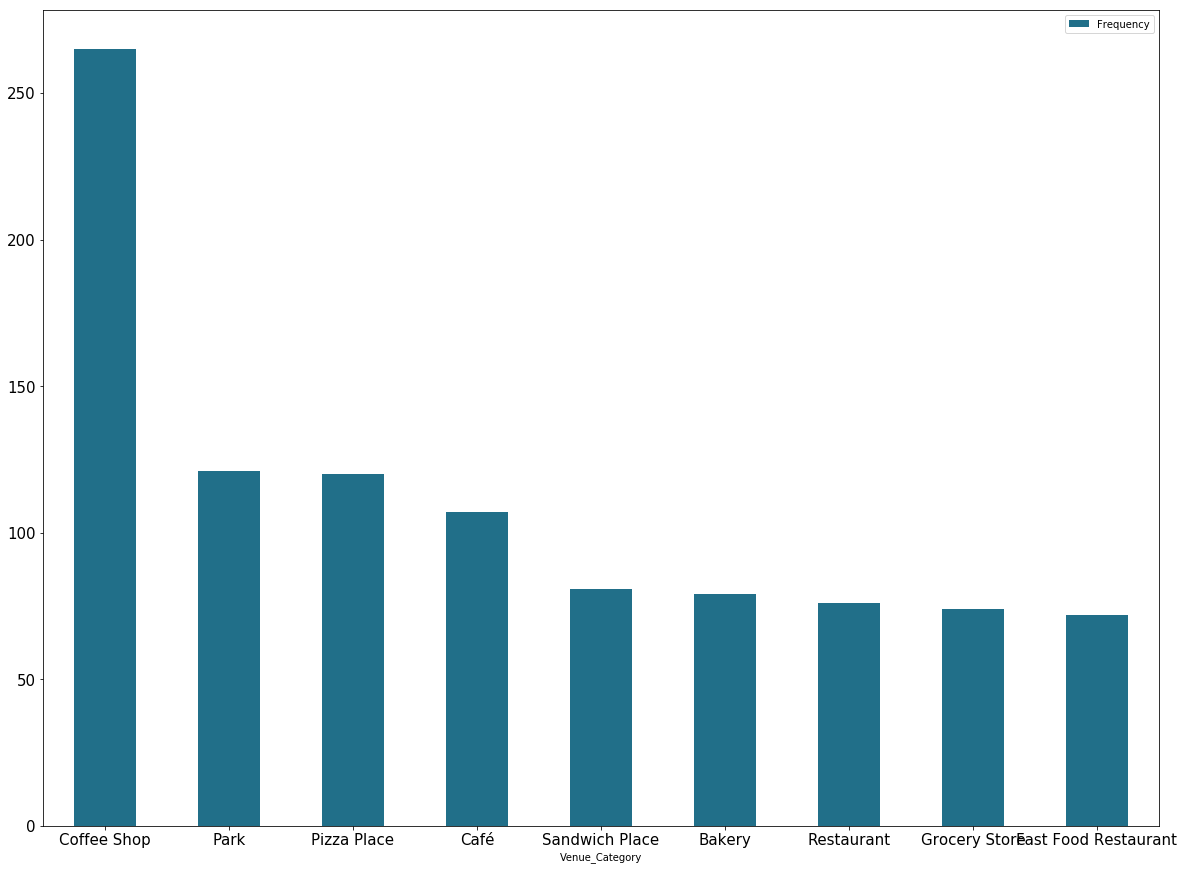

In [28]:
df_top10=df_top10=pd.DataFrame(venues['Venue Category'].value_counts()).reset_index(drop=False)[0:9]
df_top10.columns=["Venue_Category", "Frequency"]
x=df_top10.plot.bar(x="Venue_Category", y="Frequency", rot=0, figsize=(20,15), stacked=False, color="#216F89", fontsize=15)


In [29]:
print('Total Toronto postcodes:', df_4square['PostalCode'].shape[0])
print('Total Toronto postcodes with venues:', venues['PostalCode'].unique().shape[0])

Total Toronto postcodes: 103
Total Toronto postcodes with venues: 102


In [30]:
No_venues = np.setdiff1d(df_4square['PostalCode'].values,venues['PostalCode'].unique())
df_4square[df_4square['PostalCode']==No_venues[0]]

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Radius
56,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,111.0


In [31]:
df_4square=df_4square[df_4square['PostalCode']!=No_venues[0]]
df_4square.reset_index(drop=True, inplace=True) 
df_4square['PostalCode'][54:57]

54    M5B
55    M5C
56    M5G
Name: PostalCode, dtype: object

## 4. Cluster Neighborhoods

#### 4.1 PostalCode Venues Analysis

In [32]:
venues.groupby('PostalCode').count()[0:5]

,Neighborhoods,Borough,PostalCode Latitude,PostalCode Longitude,PostalCode Radius,Venue,Venue Latitude,Venue Longitude,Venue Category
PostalCode,,,,,,,,,
M1B,36,36,36,36,36,36,36,36,36
M1C,10,10,10,10,10,10,10,10,10
M1E,26,26,26,26,26,26,26,26,26
M1G,4,4,4,4,4,4,4,4,4
M1H,25,25,25,25,25,25,25,25,25


In [33]:
pc_4square_resume=df_4square[["PostalCode","Neighborhood","Borough","Radius"]]
v1=venues.groupby('PostalCode').count()["Venue"].to_frame()
v1.reset_index(level=0, inplace=True)
pc_4square_resume["Venues"]=v1["Venue"]
pc_4square_resume[100:103]

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,PostalCode,Neighborhood,Borough,Radius,Venues
100,M9V,"Albion Gardens, Beaumond Heights, Humbergate, ...",Etobicoke,1302.0,22
101,M9W,Northwest,Etobicoke,1830.0,32


In [34]:
# one hot encoding
toronto_onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot["PostalCode"] = venues['PostalCode'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]
toronto_grouped=toronto_onehot.groupby('PostalCode').mean().reset_index()
num_top_venues = 5

for hood in toronto_grouped['PostalCode']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['PostalCode'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----M1B----
                  venue  freq
0           Zoo Exhibit  0.58
1  Fast Food Restaurant  0.08
2           Pizza Place  0.06
3      Video Game Store  0.03
4           Coffee Shop  0.03


----M1C----
            venue  freq
0     Pizza Place   0.2
1   Grocery Store   0.1
2  Breakfast Spot   0.1
3    Burger Joint   0.1
4    Neighborhood   0.1


----M1E----
                  venue  freq
0           Pizza Place  0.15
1        Breakfast Spot  0.08
2  Fast Food Restaurant  0.08
3           Coffee Shop  0.08
4  Gym / Fitness Center  0.04


----M1G----
               venue  freq
0        Coffee Shop  0.50
1               Park  0.25
2           Pharmacy  0.25
3  Accessories Store  0.00
4        Music Venue  0.00


----M1H----
               venue  freq
0             Bakery  0.12
1        Coffee Shop  0.08
2  Indian Restaurant  0.08
3           Pharmacy  0.08
4        Music Store  0.04


----M1J----
                  venue  freq
0        Sandwich Place  0.18
1  Fast Food Restaurant  0.14


In [35]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [36]:
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['PostalCode']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['PostalCode'] = toronto_grouped['PostalCode']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.tail()

,PostalCode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
97,M9N,Diner,Breakfast Spot,Pizza Place,Pharmacy,Fried Chicken Joint
98,M9P,Pizza Place,Sandwich Place,Supermarket,Intersection,Chinese Restaurant
99,M9R,Mobile Phone Shop,American Restaurant,Sandwich Place,Intersection,Shopping Mall
100,M9V,Pizza Place,Coffee Shop,Grocery Store,Fast Food Restaurant,Fried Chicken Joint
101,M9W,Coffee Shop,Hotel,Burger Joint,Sandwich Place,Racecourse


In [37]:
k_means_df=pd.merge(pc_4square_resume[["PostalCode","Radius","Venues"]], toronto_grouped, on='PostalCode', how='inner')
pc_4square_resume=pd.merge(pc_4square_resume, neighborhoods_venues_sorted, on='PostalCode', how='inner')

In [38]:
pc_4square_resume.tail()

,PostalCode,Neighborhood,Borough,Radius,Venues,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
97,M9N,Weston,York,815.0,5,Diner,Breakfast Spot,Pizza Place,Pharmacy,Fried Chicken Joint
98,M9P,Westmount,Etobicoke,815.0,11,Pizza Place,Sandwich Place,Supermarket,Intersection,Chinese Restaurant
99,M9R,"Kingsview Village, Martin Grove Gardens, Richv...",Etobicoke,993.0,15,Mobile Phone Shop,American Restaurant,Sandwich Place,Intersection,Shopping Mall
100,M9V,"Albion Gardens, Beaumond Heights, Humbergate, ...",Etobicoke,1302.0,22,Pizza Place,Coffee Shop,Grocery Store,Fast Food Restaurant,Fried Chicken Joint
101,M9W,Northwest,Etobicoke,1830.0,32,Coffee Shop,Hotel,Burger Joint,Sandwich Place,Racecourse


In [39]:
# import k-means from clustering stage
from sklearn.cluster import KMeans
kmeans_df=k_means_df.drop(['PostalCode'], axis=1)
kmeans_df[0:5]

,Radius,Venues,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Beach,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Casino,Castle,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Convenience Store,Convention Center,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Dongbei Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Entertainment Service,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fireworks Store,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fraternity House,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hong Kong Restaurant,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundry Service,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Supply Store,Outdoors & Recreation,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Photography Lab,Pilates Studio,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Pub,Racecourse,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,River,Road,Rock Climbing Spot,Rock Club,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Skating Rink,Ski Area,Ski Chalet,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,S

In [40]:

# set number of clusters
kclusters = 5


# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(kmeans_df)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 3, 4, 4, 3, 3, 4, 3, 3], dtype=int32)

In [41]:
pc_4square_resume.insert(0, 'Cluster Labels', kmeans.labels_)
pc_4square_resume.sample(n=10)

,Cluster Labels,PostalCode,Neighborhood,Borough,Radius,Venues,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
40,0,M4J,East Toronto,East York,651.0,27,Coffee Shop,Convenience Store,Café,Electronics Store,Dim Sum Restaurant
4,4,M1H,Cedarbrae,Scarborough,913.0,25,Bakery,Indian Restaurant,Pharmacy,Coffee Shop,Pizza Place
99,4,M9R,"Kingsview Village, Martin Grove Gardens, Richv...",Etobicoke,993.0,15,Mobile Phone Shop,American Restaurant,Sandwich Place,Intersection,Shopping Mall
46,0,M4R,North Toronto West,Central Toronto,497.0,15,Coffee Shop,Dessert Shop,Park,Spa,Mexican Restaurant
32,0,M3M,Downsview Central,North York,739.0,6,Home Service,Korean Restaurant,Vietnamese Restaurant,Photography Lab,Outdoor Supply Store
50,0,M4W,Rosedale,Downtown Toronto,601.0,5,Park,Playground,Trail,Zoo Exhibit,Dive Bar
21,4,M2M,"Newtonbrook, Willowdale",North York,911.0,27,Korean Restaurant,Pizza Place,Coffee Shop,Café,Shopping Mall
33,3,M3N,Downsview Northwest,North York,1378.0,25,Pizza Place,Coffee Shop,Fast Food Restaurant,Tennis Stadium,Hotel
92,3,M9A,Islington Avenue,Etobicoke,1288.0,20,Pharmacy,Park,Grocery Store,Playground,Bakery
16,1,M1X,Upper Rouge,Scarborough,1698.0,4,Sculpture Garden,Playground,Farm,Trail,Zoo Exhibit


In [42]:
pc_4square_resume[["Latitude","Longitude"]]=df_4square[["Latitude","Longitude"]]


In [44]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
Toronto_map = folium.Map(location=[latitude, longitude], zoom_start=12)
# add markers and personalized radius to map
for lat, lng, borough, poi, r, cluster in zip(pc_4square_resume['Latitude'], pc_4square_resume['Longitude'], pc_4square_resume['Borough'], pc_4square_resume['Neighborhood'], pc_4square_resume["Radius"], pc_4square_resume['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7,
        parse_html=False).add_to(Toronto_map)  
    folium.Circle(
        radius=r,
        popup=label,
        location=[lat, lng],
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(Toronto_map) 
Toronto_map